In [63]:
import pandas as pd
import pickle 
import numpy as np
import networkx as nx
import re
from collections import Counter

ROOT_PATH = '/home/chiwon/workspace/vmh_workbook/mangoflavoured.github.io'
graphs = ["Colorectal", "IBD", "Obesity", "T2D", "WT2D"] #Cirrhosis: error

In [34]:
with open(f"{ROOT_PATH}/data/mm-graph/preprocessed_T2D.pkl", "rb") as h:
    t2d_dict = pickle.load(h)
    print(t2d_dict.keys())

dict_keys(['abundance_profile', 'marker_profile', 'microbe_names', 'fold_idx_1', 'fold_idx_2', 'fold_idx_3', 'fold_idx_4', 'fold_idx_5'])


In [35]:
for key in col_dict.keys():
    print(type(col_dict[key]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'list'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


In [37]:
t2d_abundance = pd.DataFrame(t2d_dict["abundance_profile"])
t2d_marker = pd.DataFrame(t2d_dict["marker_profile"])
t2d_abundance.to_csv(f"{ROOT_PATH}/data/mm-graph/T2D_Abundance_Profile.csv")
t2d_marker.to_csv(f"{ROOT_PATH}/data/mm-graph/T2D_Marker_Profile.csv")

In [38]:
t2d_marker.shape

(344, 120001)

In [60]:
t2d_marker.head()

dataset_name,ID@subjectID,CLI@bodysite,Y@disease,CLI@age,CLI@gender,CLI@country,CLI@sequencing_technology,CLI@pubmedid,CLI@camp,CLI@paired_end_insert_size,...,X@gi|83286007|ref|XM_724880.1|,X@gi|83591340|ref|NC_007643.1|:3854287-3855165,X@gi|83956146|ref|NZ_AALZ01000014.1|:c71868-71287,X@gi|84389706|ref|NZ_AAMR01000024.1|:c62016-61705,X@gi|85057280|ref|NC_007716.1|:178414-178599,X@gi|85057280|ref|NC_007716.1|:195234-195935,X@gi|88607955|ref|NC_007798.1|:118090-119082,X@gi|88797415|ref|NZ_AAOE01000002.1|:c235147-234506,X@gi|89892746|ref|NC_007907.1|:c3938880-3937900,X@gi|94502223|ref|NZ_AANL01000001.1|:c8848-8444
ID@sampleID,,,,,,,,,,,,,,,,,,,,,
CON-001,con-001,stool,n,21,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-002,con-002,stool,n,53,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-003,con-003,stool,n,61,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-004,con-004,stool,n,55,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-005,con-005,stool,n,53,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0


In [61]:
#Microbe count
match = "X@gi"
for column in t2d_marker.columns:
    if re.match(match, column):
        c += 1
    else:
        continue
print(f"NUMBER OF MICROBES: {c}")

NUMBER OF MICROBES: 119793


In [62]:
#Sequencing tech tyoes
sequencing_tech = t2d_marker["CLI@sequencing_technology"].unique().tolist()
for tech in sequencing_tech:
    print(tech)

Illumina


In [64]:
#gender distribution
gender = t2d_marker["CLI@gender"].tolist()
c = Counter(gender)
print(c)

Counter({'male': 190, 'female': 154})


In [59]:
#checking duplicates
column_list = list(t2d_marker.columns)
column_set = set(column_list)
if len(list(column_set)) == len(column_list):
    print("NO DUPLICATES")
else:
    print("DUPLICATES DETECTED")

NO DUPLICATES


In [66]:
#overall sparsity of microbes
t2d_marker_microbes = t2d_marker.filter(regex = "^X@gi")
t2d_marker_microbes = t2d_marker_microbes.astype(int)
t2d_matrix = t2d_marker_microbes.to_numpy()
print("SPARSITY: {}".format((t2d_matrix ==0).mean()))

SPARSITY: 0.8880357251018044


In [65]:
#label counts
label_count = len(t2d_marker)
label_false = t2d_marker.loc[t2d_marker["Y@disease"] == "n"]
false_count = len(label_false)
true_count = label_count - false_count

print(f"TOTAL: {label_count}\nTRUE_NEG: {false_count}\nTRUE_POS: {true_count}")

TOTAL: 344
TRUE_NEG: 174
TRUE_POS: 170


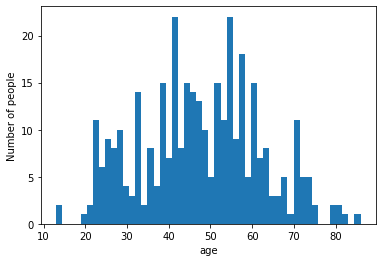

mean age:47.526162790697676


In [58]:
#age distribution
import matplotlib.pyplot as plt
age_list = list(t2d_marker["CLI@age"].astype(int))
n_bins=50
plt.hist(age_list, n_bins)
plt.xlabel("age")
plt.ylabel("Number of people")
plt.show()
print(f"mean age:{np.array(age_list).mean()}")

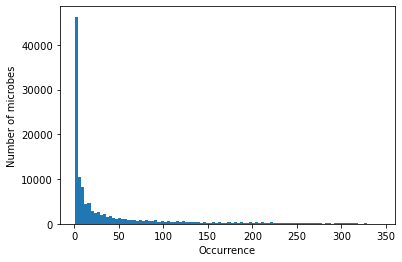

No 0 occurence microbe found


In [95]:
#bacteria abundance distribution
bacteria_count = np.count_nonzero(t2d_matrix, axis=0)
plt.hist(bacteria_count, 100)
plt.xlabel("Occurrence")
plt.ylabel("Number of microbes")
plt.show()

#checking number of bacterias with 0 occurences
if 0 in list(np.unique(bacteria_count)):
    print("0 occurence microbe found")
else: print("No 0 occurence microbe found")

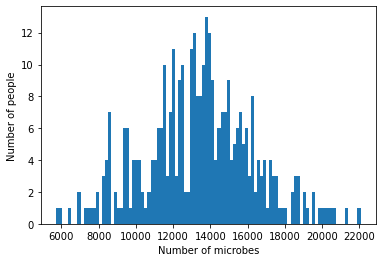

In [94]:
#Distribution of no. of bacteria in people
bacteria_per_person = np.count_nonzero(t2d_matrix, axis=1)
plt.hist(bacteria_per_person, 100)
plt.xlabel("Number of microbes")
plt.ylabel("Number of people")
plt.show()

In [115]:
#"Useless" columns
cli_features = t2d_marker.filter(regex = "^CLI@")
onecount = 0
useless_columns = []
for col in cli_features.columns:
    if (len(cli_features[col].unique()) == 1):
        #print(cli_features[col].unique())
        onecount +=1
        useless_columns.append(col)

print("FEATURES WITH ONLY ONE VALUE:", onecount)
#for col in useless_columns:
#    print(col)

FEATURES WITH ONLY ONE VALUE: 190
